In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
from array import array
from sklearn.cluster import KMeans
from sklearn.metrics import precision_score
import random
from sklearn.neural_network import MLPClassifier

## 1.0 Data preprocessing

In [38]:
"""
this part is preprocessing data from csv file
"""
# train dataset - used for model to train itself
train_embedding = pd.read_csv('dataset/train_embedding.csv')
train_embedding_comment = train_embedding.iloc[:,26:].values.tolist()
train_embedding_toxicity = train_embedding['Toxicity'].values.tolist()

x_train = train_embedding_comment
y_train = train_embedding_toxicity

# prediction dataset - used for model to make prediction and evaluate result
dev_embedding = pd.read_csv('dataset/dev_embedding.csv')
dev_embedding_comment = dev_embedding.iloc[:,26:].values.tolist()
dev_embedding_toxicity = dev_embedding['Toxicity'].values.tolist()

x_predict = dev_embedding_comment
y_answer = dev_embedding_toxicity

# identifier dataset - used for one-r baseline
dev_embedding_identifier = dev_embedding.iloc[:,2:26].values.tolist()

# unlabeled dataset - used for unsupervised learning model and semi-supervising learning model
unlabeled_embedding = pd.read_csv('dataset/unlabeled_embedding.csv')
unlabeled_embedding_comment = unlabeled_embedding.iloc[:,1:].values.tolist()

# test dataset - used for producing kaggle competition result
test_embedding = pd.read_csv('dataset/test_embedding.csv')
test_embedding_comment = test_embedding.iloc[:,26:].values.tolist()

<AxesSubplot:>

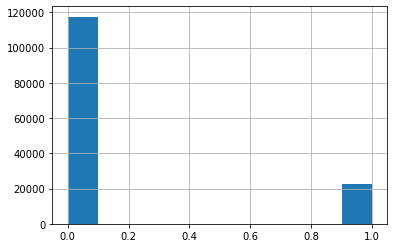

In [120]:
"""
this part is to demonstrate the label distribution of toxic and non-toxic labels from training dataset
"""

train_embedding.loc[:,"Toxicity"].hist()

<AxesSubplot:>

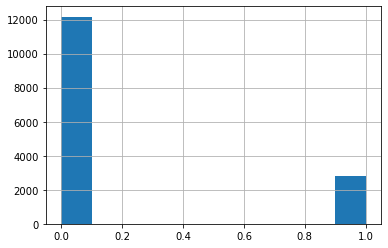

In [121]:
"""
this part is to demonstrate the label distribution of toxic and non-toxic labels from prediction dataset
"""

dev_embedding.loc[:,"Toxicity"].hist()

## 2.0 One-r baseline model

In [14]:
"""
One-r baseline section
This implementation iterates through each identifier, use the idf as the guide to predict the result
"""

accu_scores = []
pres_scores = []
for i in range(len(dev_embedding_identifier[0])):
    testline = []
    for j in range(len(dev_embedding_identifier)):
        testline.append(dev_embedding_identifier[j][i])
    t_arr = np.array(testline)
    a = accuracy_score(y_answer, t_arr)
    p = precision_score(y_answer, t_arr, pos_label=1)
    accu_scores.append(a)
    pres_scores.append(p)


max = 0
idx = 0
for i in range(len(pres_scores)):
    if pres_scores[i] > max:
        max = pres_scores[i]
        idx = i

print("max pres:", pres_scores[idx], idx)
print("max accu:", accu_scores[idx], idx)
print("Best identifier:", list(dev_embedding.columns)[idx+2])

max pres: 0.35058922558922556 3
max accu: 0.7636666666666667 3
Best identifier: Black


/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
"""
Full results
"""

for i in range(len(pres_scores)):
    print("pres:", pres_scores[i], i)
    print("accu:", accu_scores[i], i)
    print("identifier:", list(dev_embedding.columns)[i+2])   

pres: 0.15916955017301038 0
accu: 0.7978666666666666 0
identifier: Asian
pres: 0.13291139240506328 1
accu: 0.8032666666666667 1
identifier: Atheist
pres: 0.20689655172413793 2
accu: 0.8098666666666666 2
identifier: Bisexual
pres: 0.35058922558922556 3
accu: 0.7636666666666667 3
identifier: Black
pres: 0.12244897959183673 4
accu: 0.8085333333333333 4
identifier: Buddhist
pres: 0.09638932496075353 5
accu: 0.6396 5
identifier: Christian
pres: 0.14913999564554759 6
accu: 0.5961333333333333 6
identifier: Female
pres: 0.18666666666666668 7
accu: 0.8047333333333333 7
identifier: Heterosexual
pres: 0.0425531914893617 8
accu: 0.8081333333333334 8
identifier: Hindu
pres: 0.26672950047125354 9
accu: 0.778 9
identifier: Homosexual gay or lesbian
pres: 0.0 10
accu: 0.8105333333333333 10
identifier: Intellectual or learning disability
pres: 0.17381974248927037 11
accu: 0.7907333333333333 11
identifier: Jewish
pres: 0.21686746987951808 12
accu: 0.8047333333333333 12
identifier: Latino
pres: 0.1687883

## 2.2.1 Naive Bayes

In [36]:
"""
Preliminarily check naive bayes's performance against prediction dataset
"""

# param tunining
from sklearn.model_selection import GridSearchCV

nb_classifier = GaussianNB()
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
gs_NB = GridSearchCV(estimator=nb_classifier, param_grid=params_NB, verbose=1, scoring='precision')
gs_NB.fit(x_train, y_train)
best_var = gs_NB.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [42]:
print(best_var)

{'var_smoothing': 0.0002310129700083158}


In [44]:
# model with best var smoothing val
gnb = GaussianNB(var_smoothing=0.0002310129700083158)
gnb.fit(x_train, y_train)
pred = gnb.predict(x_predict)

In [46]:
print("GNB", classification_report(y_answer, pred, digits=4))

GNB               precision    recall  f1-score   support

           0     0.9045    0.6817    0.7774     12165
           1     0.3360    0.6910    0.4521      2835

    accuracy                         0.6835     15000
   macro avg     0.6202    0.6864    0.6148     15000
weighted avg     0.7970    0.6835    0.7160     15000



## 2.2.2 Logistic regression

In [31]:
"""
Preliminarily check naive bayes's performance against prediction dataset
"""

# logistic regression with pre defined c_vals

# c_values = [0.001]
c_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

accuracy_list = []
precision_list = []

curr_max = 0
best_c_val = 0

for c_val in c_values:
    lrclf = LogisticRegression(penalty='l1', solver='liblinear', C = c_val)
    lrclf.fit(x_train, y_train)
    pred = lrclf.predict(x_predict)
    accu_score = accuracy_score(y_answer, pred)
    pres_score = precision_score(y_answer, pred)

    accuracy_list.append(accu_score)
    precision_list.append(pres_score)

    if pres_score > curr_max:
        curr_max = pres_score
        best_c_val = c_val

print(best_c_val)
        

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.01


In [34]:
# after obtain best c val, set up a new model and do classification report
lrclf = LogisticRegression(penalty='l1', solver='liblinear', C = 0.01)
lrclf.fit(x_train, y_train)
pred = lrclf.predict(x_predict)

print("LogisticRegression", classification_report(y_answer, pred, digits=4))

LogisticRegression               precision    recall  f1-score   support

           0     0.8139    0.9989    0.8970     12165
           1     0.8143    0.0201    0.0392      2835

    accuracy                         0.8139     15000
   macro avg     0.8141    0.5095    0.4681     15000
weighted avg     0.8140    0.8139    0.7349     15000



## 2.2.3 Neural network

In [ ]:
"""
Preliminarily check neural network's performance against prediction dataset
"""

mlpclf = MLPClassifier(random_state=1, max_iter=300).fit(x_train, y_train)
pred = mlpclf.predict(x_predict)

In [ ]:
print(classification_report(y_answer,pred))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87     12165
           1       0.43      0.40      0.41      2835

    accuracy                           0.79     15000
   macro avg       0.65      0.64      0.64     15000
weighted avg       0.78      0.79      0.78     15000



## 3.0 Logistic regression semi-supervised

In [55]:
"""
After comparing supervised learning models, choose Logistic Regression as the base model for semi-supervised learning
"""

base = LogisticRegression(penalty='l1', solver='liblinear', C = 0.01)

In [86]:
def semi_super_lr(x_train,y_train):
    stclf = SelfTrainingClassifier(base)
    stclf.fit(x_train,y_train)
    pred = stclf.predict(x_predict)
    accu = accuracy_score(y_answer,pred)
    prec = precision_score(y_answer,pred,pos_label = 1)
    return accu,prec

In [51]:
unlabeled_embedding_comment_df = pd.DataFrame(unlabeled_embedding_comment)

In [89]:
"""
Designing a test to gradually feed unlabelled data to semi-super model, to find out the effectiveness
"""

def run_semi_super_lr():
    unlabeled_data_amount = []
    accu_log = []
    prec_log = []

    data_fractions = [0.001, 0.01, 0.1, 0.2, 0.5, 1]

    for a_fraction in data_fractions:

        x_train_unlabel = unlabeled_embedding_comment_df.sample(frac=a_fraction, random_state = 1)
        y_train_unlabel = []
        frac_size = 200000*a_fraction
        for i in range(int(frac_size)):
            y_train_unlabel.append(-1)

        # combine lablelled x with unlabelled x
        x_train_df = pd.DataFrame(x_train)
        x_train_cb = pd.concat([x_train_df, x_train_unlabel]).reset_index(drop = True)

        # combine lablelled y with unlabelled y
        y_train_df = pd.DataFrame(y_train)
        y_train_unlabel = pd.DataFrame(y_train_unlabel)
        y_train_cb = pd.concat([y_train_df, y_train_unlabel]).reset_index(drop = True)

        accu, prec = semi_super_lr(x_train_cb, y_train_cb)
        unlabeled_data_amount.append(frac_size)
        accu_log.append(accu)
        prec_log.append(prec)
    
    return unlabeled_data_amount, accu_log, prec_log

In [90]:
unlabeled_data_amount, accu_log, prec_log = run_semi_super_lr()

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

In [92]:
unlabeled_data_amount

[200.0, 2000.0, 20000.0, 40000.0, 100000.0, 200000]

In [93]:
accu_log

[0.8139333333333333,
 0.8137333333333333,
 0.8137333333333333,
 0.8132,
 0.8131333333333334,
 0.8130666666666667]

In [94]:
prec_log

[0.8142857142857143,
 0.8059701492537313,
 0.8253968253968254,
 0.7619047619047619,
 0.7105263157894737,
 0.7012987012987013]

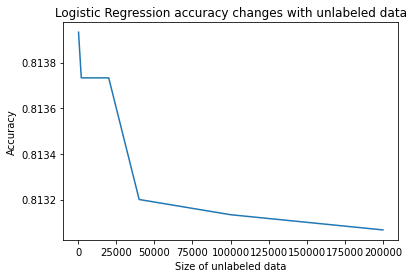

In [99]:
plt.plot(unlabeled_data_amount, accu_log)
plt.xlabel("Size of unlabeled data")
plt.ylabel("Accuracy")
plt.title("Logistic Regression accuracy changes with unlabeled data")
plt.show()

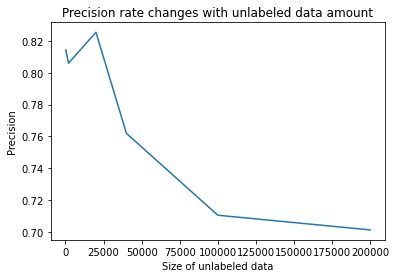

In [102]:
plt.plot(unlabeled_data_amount, prec_log)
plt.xlabel("Size of unlabeled data")
plt.ylabel("Precision")
plt.title("Precision rate changes with unlabeled data amount")
plt.show()

In [ ]:
"""
To generate classification_report when unlabelled data amount is 20,000
"""
x_train_unlabel = unlabeled_embedding_comment_df.sample(frac=0.1, random_state = 1)
y_train_unlabel = []
frac_size = 20000
for i in range(int(frac_size)):
    y_train_unlabel.append(-1)

# combine lablelled x with unlabelled x
x_train_df = pd.DataFrame(x_train)
x_train_cb = pd.concat([x_train_df, x_train_unlabel]).reset_index(drop = True)

# combine lablelled y with unlabelled y
y_train_df = pd.DataFrame(y_train)
y_train_unlabel = pd.DataFrame(y_train_unlabel)
y_train_cb = pd.concat([y_train_df, y_train_unlabel]).reset_index(drop = True)

base = LogisticRegression(penalty='l1', solver='liblinear', C = 0.01)
stclf = SelfTrainingClassifier(base)
stclf.fit(x_train_cb,y_train_cb)
pred = stclf.predict(x_predict)

In [101]:
print(classification_report(y_answer,pred,digits=4))

              precision    recall  f1-score   support

           0     0.8137    0.9991    0.8969     12165
           1     0.8254    0.0183    0.0359      2835

    accuracy                         0.8137     15000
   macro avg     0.8195    0.5087    0.4664     15000
weighted avg     0.8159    0.8137    0.7342     15000



## 4.0 K Means

In [47]:
"""
Preliminarily check k means's performance against prediction dataset
"""

km = KMeans(n_clusters=2, n_init=10, random_state=0).fit(x_train)
pred = km.predict(x_predict)


In [48]:
print(classification_report(y_answer,pred, digits=4))

              precision    recall  f1-score   support

           0     0.7762    0.7117    0.7425     12165
           1     0.0879    0.1192    0.1012      2835

    accuracy                         0.5997     15000
   macro avg     0.4320    0.4155    0.4219     15000
weighted avg     0.6461    0.5997    0.6213     15000

